# CS448 - Lab 10: Spectral Factorizations

In [1]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

plt.rcParams["figure.figsize"] = (5, 3)

In [2]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=""):
    from IPython.display import display, Audio, HTML
    display(
        HTML("<style> table, th, td {border: 0px; }</style> <table><tr><td>" +
             label + "</td><td>" + Audio(x, rate=rate)._repr_html_()[3:] +
             "</td></tr></table>"))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


# Function that plots the spectrogram of a signal
def plot_spectrogram(stft,
                     dft_size,
                     hop_size,
                     zero_pad,
                     fs,
                     title="Spectrogram"):
    # Raising to a power of 0.3 to make the spectrogram more visible
    output = np.absolute(stft)**0.3
    X = np.linspace(0, output.shape[0] * hop_size / fs, output.shape[0])
    Y = np.linspace(0, fs / 2, int((dft_size + zero_pad) / 2 + 1))

    plt.pcolormesh(X, Y, output.T)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (HZ)")
    plt.title(title)
    plt.show()


# Function that plots the waveform of a signal
def plot_waveform(input_sound, fs, title='Waveform'):
    plt.plot(np.linspace(0,
                         len(input_sound) / fs, len(input_sound)), input_sound)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.show()

In [3]:
# STFT from Lab 1
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    # Creating the n-1 frames
    frames = []
    idx = 0
    for idx in range(0, len(input_sound) - dft_size, hop_size):
        frames.append(np.multiply(input_sound[idx:idx + dft_size], window))
    idx += hop_size

    # Creating the last frame accounting for padding
    last_frame = np.multiply(
        np.append(input_sound[idx:-1],
                  np.zeros(idx + dft_size - len(input_sound) + 1)),
        window,
    )
    frames.append(last_frame)

    # Convert to numpy array
    frames = np.array(frames, dtype=float)

    # Compute the DFT of each frame
    dft_frames = np.fft.rfft(frames, dft_size + zero_pad)
    return dft_frames


# ISTFT from Lab 1
def istft(input_sound, dft_size, hop_size, zero_pad, window):
    # Calculate the length of the output signal
    signal_length = hop_size * (len(input_sound) - 1) + dft_size + zero_pad
    signal = np.zeros(signal_length, dtype=complex)

    # Iterate over the input_sound rows
    for idx, row in enumerate(input_sound):
        # Compute the inverse real FFT and apply the window function
        frame = np.multiply(
            np.fft.irfft(row, dft_size + zero_pad)[:dft_size], window)
        # Add the frame to the output signal
        signal[idx * hop_size:idx * hop_size + dft_size] += frame

    return signal

## Part 1. Learning Spectral Components

In this part we will design a simple component analyzer. Use the sound file [https://drive.google.com/uc?export=download&id=1fyHhUqYVOrIPzSMJoQC78sqeokjqI4ib]. This is a drum loop with four distinct sounds (bass drum, snare drum, cymbal and synthetic bell sound). We will use a spectral factorization that will allow us to extract them all. Obtain the STFT of this signal and use a DFT size of 4096, a hop size of 256 and a Hann window. This will be stored in a matrix $\mathbf F$ whose size will be $M$ by $N$. 

You now need to implement a factorization technique. This is defined as:

$$|\mathbf F | \approx \mathbf{W} \cdot \mathbf{H}$$
$$\mathbf{F} \in \mathbb{R}^{M\times N}_+, \mathbf{W} \in \mathbb{R}^{M\times K}_+, \mathbf{H} \in \mathbb{R}^{K\times N}_+$$

Where $\mathbb{R}^{A\times B}_+$ is the set of matrices of size $A \times B$ containing non-negative elements, and $|\mathbf{F}|$ takes the absolute value of the STFT matrix $\mathbf{F}$.  In this case we will use $K$=4 since the mix we are analyzing has four distinct sounds.  To estimate the values of $\mathbf{W}$ and $\mathbf{H}$ start by filling them with uniformly random values between 10 to 11 and iterate over the following equations:

$$\mathbf{V} = \frac{|\mathbf{F}|}{\mathbf{W}\cdot \mathbf{H} + \epsilon}$$
$$\mathbf{H} = \mathbf{H} \odot \left[ \mathbf{W}^\top \cdot \mathbf{V} \right]$$
$$\mathbf{W} = \mathbf{W} \odot \left[ \mathbf{V} \cdot \mathbf{H}^\top \right]$$

Where $\odot$ denotes element-wise multiplication and the fraction performs element-wise division.  The constant $\epsilon$ is assigned to a small value (e.g. 1e-7) to avoid division by zero. After each pass normalize the columns of $\mathbf{W}$ to sum to 1.  Iterate for about 100 times.

Plot the columns of $\mathbf{W}$ and explain what they correspond to. Plot the rows of $\mathbf{H}$ and explain them as well. You might have to run the above procedure a couple of times since in some cases the results can come up wrong. Just to be safe, run this a dozen times and show the results that are representative of the majority of the outputs (note that each time the ordering will be different, we only care about the shapes of these quantities, not their order).

You can now try to extract each component. Take each column of $\mathbf{W}$ and compute its outer product with its corresponding row of $\mathbf{H}$. This will approximate only one component of the input spectrogram. Plot all four products and explain what they look like. Use the phase of the original input to invert these resulting spectrograms to the time domain and listen to them. What do they sound like?

80s-hi.wav


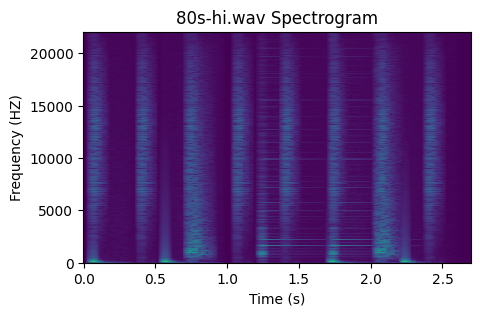

In [4]:
# STFT Parameters & Constants
DFT_SIZE = 4096
HOP_SIZE = 256
ZERO_PAD = 0
WINDOW = np.hanning(DFT_SIZE)

K = 4
GRAPH_COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']


# Load the audio file
fs, drums = wavfile.read("./data/80s-hi.wav")
drums = normalize_signal(drums)
sound(drums, fs, "80s-hi.wav")

# Padding the signal
drums = np.concatenate((np.zeros(5000), drums))

F = stft(drums, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW).T
plot_spectrogram(F.T,
                 DFT_SIZE,
                 HOP_SIZE,
                 ZERO_PAD,
                 fs,
                 title="80s-hi.wav Spectrogram")

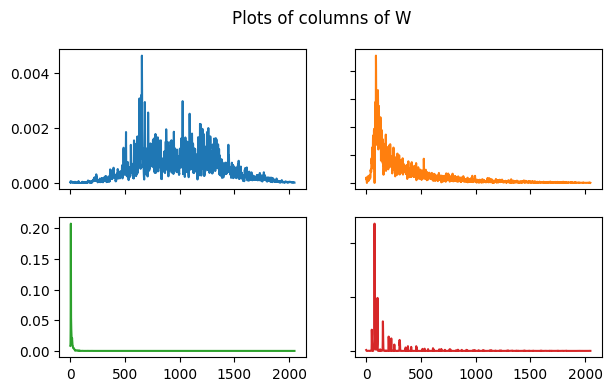

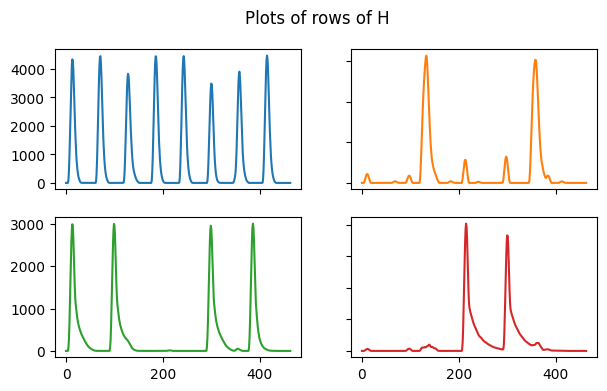

In [5]:
num_rows, num_cols = F.shape

# Filling W & H with uniformly random values between 10 to 11
W = np.random.uniform(low=10, high=11, size=(num_rows, K))
H = np.random.uniform(low=10, high=11, size=(K, num_cols))

# Iterating over the given equations
for j in range(K):
    W[:, j] /= np.sum(W[:, j])

for i in range(100):
    V = np.absolute(F) / (W @ H + 1e-7)
    H = H * (W.T @ V)
    W = W * (V @ H.T)

    for j in range(K):
        W[:, j] /= np.sum(W[:, j])

# Plotting the columns of W
plt.rcParams["figure.figsize"] = (7, 4)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Plots of columns of W')
for i in range(K):
    eval(f"ax{i+1}").plot(W[:, i], GRAPH_COLORS[i])
for ax in fig.get_axes():
    ax.label_outer()

# Plotting the rows of H
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Plots of rows of H')
for i in range(K):
    eval(f"ax{i+1}").plot(H[i, :], GRAPH_COLORS[i])
for ax in fig.get_axes():
    ax.label_outer()


### Findings about $\mathbf{W}$ and $\mathbf{H}$


__Columns of $\mathbf{W}$:__ Each column of the matrix $\mathbf{W}$ contains a spectral pattern or signature that represents one of four different drum sounds (bass drum, snare drum, cymbal, and synthetic bell sound). By plotting these columns, you can visualize how the frequency components of each drum sound are distributed across the frequency domain.

__Rows of $\mathbf{H}$:__ The rows of $\mathbf{H}$ correspond to the temporal activation of each individual drum sound in the original drum loop. By plotting these rows, you can get a visualization of when each of the four distinct drum sounds is active.

Sound 1


Sound 2


Sound 3


Sound 4


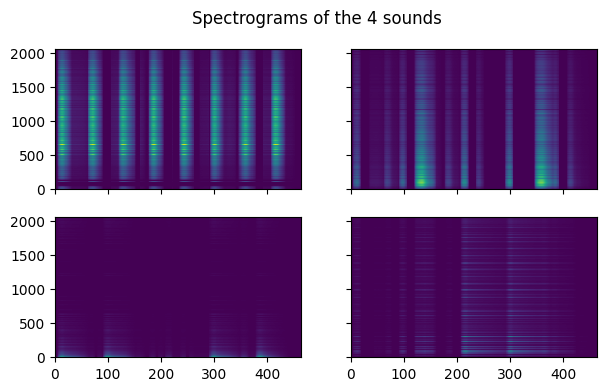

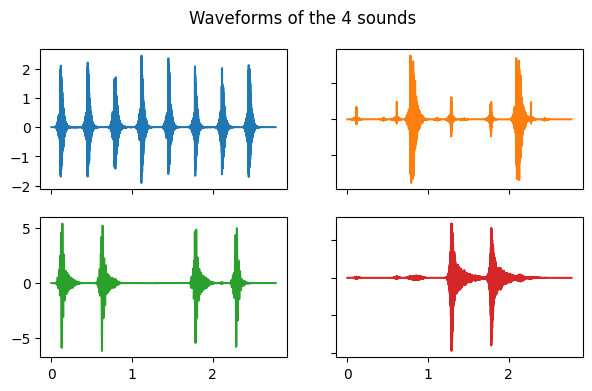

In [6]:
## Analyzing the 4 sounds ##

# Plotting the spectrograms of the 4 sounds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Spectrograms of the 4 sounds')

extracted_sounds = []
phase = np.angle(F)
for i in range(K):
    # Computing outer product
    outer_product = np.outer(W[:, i], H[i])

    eval(f'ax{i + 1}').pcolormesh(np.absolute(outer_product)**0.3)
    reconstructed_sound = istft((outer_product * phase).T, DFT_SIZE, HOP_SIZE,
                                ZERO_PAD, WINDOW)
    extracted_sounds.append(reconstructed_sound)

extracted_sounds = np.real(extracted_sounds)
for ax in fig.get_axes():
    ax.label_outer()

# Plotting the waveforms of the 4 sounds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Waveforms of the 4 sounds')
for i in range(K):
    eval(f'ax{i + 1}').plot(
        np.linspace(0,
                    len(extracted_sounds[i]) / fs, len(extracted_sounds[i])),
        extracted_sounds[i], GRAPH_COLORS[i])
for ax in fig.get_axes():
    ax.label_outer()

plt.rcParams["figure.figsize"] = (5, 3)

# Playing the 4 sounds
for i in range(K):
    sound(extracted_sounds[i], fs, f"Sound {i + 1}")

Reconstructed 80s-hi.wav


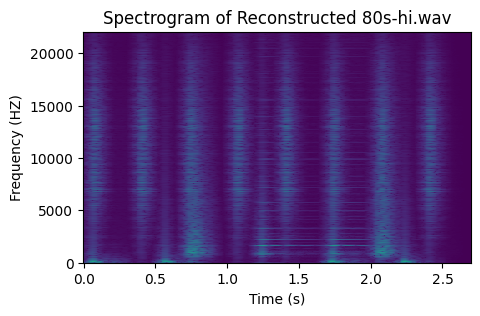

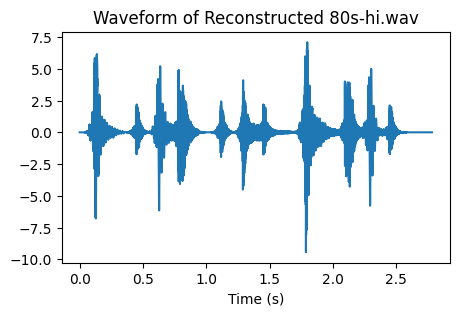

In [7]:
## Reconstruction of the original sound ##
reconstructed_drums = np.sum(extracted_sounds, axis=0)
sound(reconstructed_drums, fs, "Reconstructed 80s-hi.wav")

plot_spectrogram(stft(reconstructed_drums, DFT_SIZE, HOP_SIZE, ZERO_PAD,
                      WINDOW),
                 DFT_SIZE,
                 HOP_SIZE,
                 ZERO_PAD,
                 fs,
                 title="Spectrogram of Reconstructed 80s-hi.wav")
plot_waveform(reconstructed_drums,
              fs,
              title="Waveform of Reconstructed 80s-hi.wav")

## Part 2: Training Dictionaries for Source Separation

In this section we will design a system that separates speech of a known speaker from a known type of noise. Use the sound files [https://drive.google.com/uc?export=download&id=1fhTSrXDDbsp06oqlrBL9p9JToC4Mws11 ] and [https://drive.google.com/uc?export=download&id=1fmtVWSLp5ZB5_pkFvr8BEXSj0bRuNe70] from the lab archive.

One of them is of speech and the other one of chimes. Take the first sentence of the speech sound and a segment which is just as long from the beginning of the chime sound and add them together. This will be a mixture that we will try to separate. The rest of the data we will use for training dictionary models.
Taking the rest of the speech data run a factorization as we’ve done above with $K$ = 40. Do the same with the remaining chime sound. From these you will obtain two matrices $\mathbf{W}_s$ and $\mathbf{W}_c$. These are the dictionaries of the two sounds. If you visually inspect them you will see that they look a lot like representative spectra of these two sounds.

In order to resolve the mixture we need to use these dictionaries to explain its spectrogram and then only use each dictionary’s contribution to resynthesize a time signal. This essentially involves finding the $\mathbf{H}$ matrix while fixing the $\mathbf{W}$ matrix to be a concatenation of $\mathbf{W}_s$ and $\mathbf{W}_c$. You can do that using the iterative approach used in the previous part, but only updating $\mathbf{H}$ and not updating $\mathbf{W}$ at every iteration. If you do this on the mixture you will ultimately get a $\mathbf{H}$ that will let us know how to combine the elements of the pretrained dictionaries to approximate the input.

To extract the two sounds you need to isolate the contribution of the two dictionaries on the mixture. That will be $\mathbf{F}_s = \mathbf{W}_s \cdot \mathbf{H}_s$ and $\mathbf{F}_c = \mathbf{W}_c \cdot \mathbf{H}_c$, where $\mathbf{H}_s$ corresponds to the first 40 rows of $\mathbf{H}$ and $\mathbf{H}_c$ to its second 40 rows. $\mathbf{F}_s$ and $\mathbf{F}_c$  will correspond to the magnitude spectrograms of the two extracted sources. Just as before use the phase of the input mixture to invert these back to the time domain and listen to them. Do they sound like they are separated? Play around with the STFT parameters until you get the best sounding results.

In [8]:
# STFT Parameters & Constants
DFT_SIZE = 4096
HOP_SIZE = 128
ZERO_PAD = 0
WINDOW = np.hanning(DFT_SIZE)

K = 40


# Load and pre-process the audio files
fs_chimes, chimes = wavfile.read("./data/chimes.wav")
chimes = normalize_signal(chimes)

fs_speaker, speaker = wavfile.read("./data/speaker.wav")
speaker = normalize_signal(speaker)

# Trimming to length of first sentence
sample_length = int(fs_speaker * 3.69)

chimes_trim = chimes[:sample_length]
sound(chimes_trim, fs_chimes, "chimes.wav (trimmed)")
chimes_train = chimes[sample_length:]

speaker_trim = speaker[:sample_length]
sound(speaker_trim, fs_speaker, "speaker.wav (trimmed)")
speaker_train = speaker[sample_length:]

combined = np.sum([chimes_trim, speaker_trim], axis=0)
sound(combined, fs_speaker, "chimes.wav + speaker.wav")

chimes.wav (trimmed)


speaker.wav (trimmed)


chimes.wav + speaker.wav


In [9]:
# Calculating Wc
F = stft(chimes_train, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW).T
num_rows, num_cols = F.shape

# Filling W & H with uniformly random values between 10 to 11
Wc = np.random.uniform(low=10, high=11, size=(num_rows, K))
H = np.random.uniform(low=10, high=11, size=(K, num_cols))

# Iterating over the given equations
for j in range(K):
    Wc[:, j] /= np.sum(Wc[:, j])

for i in range(100):
    V = np.absolute(F) / (Wc @ H + 1e-7)
    H = H * (Wc.T @ V)
    Wc = Wc * (V @ H.T)

    for j in range(K):
        Wc[:, j] /= np.sum(Wc[:, j])

In [10]:
# Calculating Ws
F = stft(speaker_train, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW).T
num_rows, num_cols = F.shape

# Filling W & H with uniformly random values between 10 to 11
Ws = np.random.uniform(low=10, high=11, size=(num_rows, K))
H = np.random.uniform(low=10, high=11, size=(K, num_cols))

# Iterating over the given equations
for j in range(K):
    Ws[:, j] /= np.sum(Ws[:, j])

for i in range(100):
    V = np.absolute(F) / (Ws @ H + 1e-7)
    H = H * (Ws.T @ V)
    Ws = Ws * (V @ H.T)

    for j in range(K):
        Ws[:, j] /= np.sum(Ws[:, j])

In [11]:
# Calculating H
W = np.hstack([Wc, Ws])

F = stft(combined, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW).T
H = np.random.uniform(low=10, high=11, size=(K * 2, F.shape[1]))

for i in range(100):
    H *= (W.T @ (np.abs(F) / (W @ H + 1e-7)))

Hc, Hs = np.split(H, 2, axis=0)

Reconstructed chimes.wav


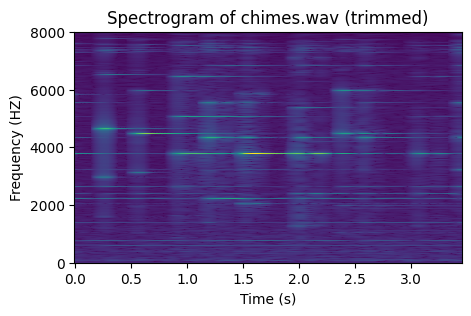

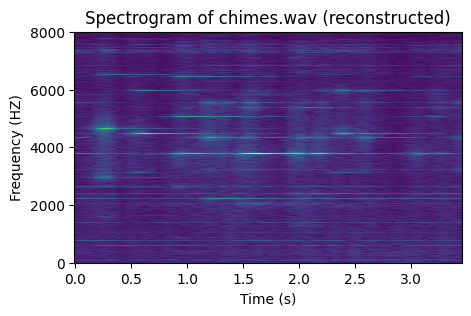

In [12]:
# Reconstruction of the chimes
Fc = Wc @ Hc

sounds = []
combined_stft = stft(combined, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)

for _ in range(K):
    # Calculate the modified STFT by multiplying Fc with the phase of the combined STFT
    modified_stft = (Fc * np.angle(combined_stft.T)).T
    # Calculate the inverse STFT to get the time-domain signal
    sound_signal = istft(modified_stft, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
    sounds.append(sound_signal)

# Sum the individual sounds to obtain the reconstructed signal
chimes_reconstructed = np.real(np.sum(sounds, axis=0))
sound(chimes_reconstructed, fs_chimes, "Reconstructed chimes.wav")

plot_spectrogram(stft(chimes_trim, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW),
                 DFT_SIZE,
                 HOP_SIZE,
                 ZERO_PAD,
                 fs_chimes,
                 title="Spectrogram of chimes.wav (trimmed)")

plot_spectrogram(stft(chimes_reconstructed, DFT_SIZE, HOP_SIZE, ZERO_PAD,
                      WINDOW),
                 DFT_SIZE,
                 HOP_SIZE,
                 ZERO_PAD,
                 fs_chimes,
                 title="Spectrogram of chimes.wav (reconstructed)")

Reconstructed speaker.wav


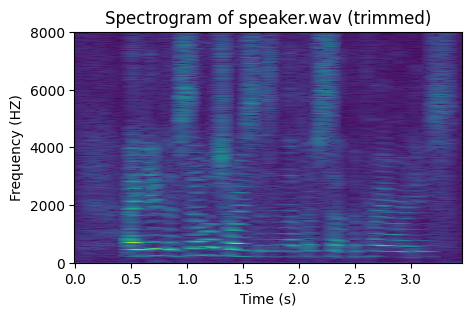

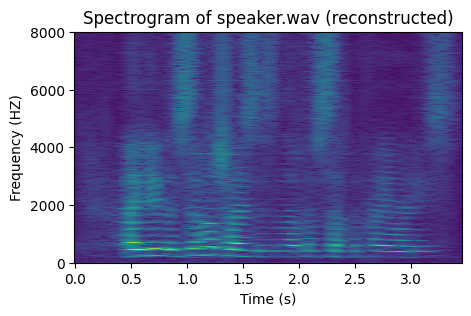

In [13]:
# Reconstruction of the speaker
Fs = Ws @ Hs

sounds = []
combined_stft = stft(combined, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)

for _ in range(K):
    # Calculate the modified STFT by multiplying Fc with the phase of the combined STFT
    modified_stft = (Fs * np.angle(combined_stft.T)).T
    # Calculate the inverse STFT to get the time-domain signal
    sound_signal = istft(modified_stft, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
    sounds.append(sound_signal)

# Sum the individual sounds to obtain the reconstructed signal
speaker_reconstructed = np.real(np.sum(sounds, axis=0))
sound(speaker_reconstructed, fs_speaker, "Reconstructed speaker.wav")

plot_spectrogram(stft(speaker_trim, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW),
                 DFT_SIZE,
                 HOP_SIZE,
                 ZERO_PAD,
                 fs_speaker,
                 title="Spectrogram of speaker.wav (trimmed)")

plot_spectrogram(stft(speaker_reconstructed, DFT_SIZE, HOP_SIZE, ZERO_PAD,
                      WINDOW),
                 DFT_SIZE,
                 HOP_SIZE,
                 ZERO_PAD,
                 fs_speaker,
                 title="Spectrogram of speaker.wav (reconstructed)")
